In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Загружаем .env
load_dotenv()

# 2. Считываем параметры подключения
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_DB = os.getenv("PG_DB")

# 3. Создаём SQLAlchemy engine
connection_url = f"postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB}"
engine = create_engine(connection_url)

# 4. Загружаем таблицу raw.titanic в pandas
query = "SELECT * FROM raw.titanic;"
data = pd.read_sql(query, engine)

# 5. Проверим результат
data

,id,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,None,S
887,888,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,None,S
889,890,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [2]:
display(data.info())
display(data.describe(include=np.number))
display(data.describe(exclude=np.number))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    int64  
 4   Name         891 non-null    object 
 5   Sex          891 non-null    object 
 6   Age          714 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Cabin        204 non-null    object 
 12  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


None

,id,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,G6,S
freq,1,577,7,4,644


In [3]:
# Эти колонки не несут пользы для предсказания или слишком уникальны
data.drop(['id', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Добавим новый признак “FamilySize”
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1

# Добавим “IsAlone”
data["IsAlone"] = (data["FamilySize"] == 1).astype(int)

# Разобьем возраст по диапазонам
# data["AgeGroup"] = pd.cut(data["Age"], bins=[0, 12, 18, 30, 50, 80],
#                           labels=["Child", "Teen", "Young", "Adult", "Senior"])
# data = pd.get_dummies(data, columns=["AgeGroup"], drop_first=False, dtype=int)

# Обработать пропуски - можно заменить медианой по полу и классу
data["Age"] = data.groupby(["Sex", "Pclass"])["Age"].transform(lambda x: x.fillna(x.median()))

# Обработать пропуски - заменяем самым частым значением
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])

# Преобразуем категориальные признаки в числа
data["Sex"] = data["Sex"].map({"male": 0, "female": 1})

# OHE
data = pd.get_dummies(data, columns=['Pclass', "Embarked"], drop_first=False, dtype=int)

# Сделаем взаимодействие пола с классом
#data["Sex_Pclass_1"] = data["Sex"] * data["Pclass_1"]
#data["Sex_Pclass_2"] = data["Sex"] * data["Pclass_2"]
#data["Sex_Pclass_3"] = data["Sex"] * data["Pclass_3"]

data

,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,0,22.0,1,0,7.2500,2,0,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,2,0,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,1,1,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,2,0,1,0,0,0,0,1
4,0,0,35.0,0,0,8.0500,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,13.0000,1,1,0,1,0,0,0,1
887,1,1,19.0,0,0,30.0000,1,1,1,0,0,0,0,1
888,0,1,21.5,1,2,23.4500,4,0,0,0,1,0,0,1
889,1,0,26.0,0,0,30.0000,1,1,1,0,0,1,0,0


In [4]:
display(data.info())
display(data.describe(include=np.number))
# display(data.describe(exclude=np.number))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Sex         891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   FamilySize  891 non-null    int64  
 7   IsAlone     891 non-null    int64  
 8   Pclass_1    891 non-null    int64  
 9   Pclass_2    891 non-null    int64  
 10  Pclass_3    891 non-null    int64  
 11  Embarked_C  891 non-null    int64  
 12  Embarked_Q  891 non-null    int64  
 13  Embarked_S  891 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 97.6 KB


None

,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.352413,29.112424,0.523008,0.381594,32.204208,1.904602,0.602694,0.242424,0.206510,0.551066,0.188552,0.086420,0.725028
std,0.486592,0.477990,13.304424,1.102743,0.806057,49.693429,1.613459,0.489615,0.428790,0.405028,0.497665,0.391372,0.281141,0.446751
min,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,21.500000,0.000000,0.000000,7.910400,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,26.000000,0.000000,0.000000,14.454200,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,36.000000,1.000000,0.000000,31.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Масштабируем числовые признаки
scaler = StandardScaler()
cols_to_scale = ["Age", "Fare", "SibSp", "Parch"]
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

data

,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,0,-0.534891,0.432793,-0.473674,-0.502445,2,0,0,0,1,0,0,1
1,1,1,0.668392,0.432793,-0.473674,0.786845,2,0,1,0,0,1,0,0
2,1,1,-0.234070,-0.474545,-0.473674,-0.488854,1,1,0,0,1,0,0,1
3,1,1,0.442776,0.432793,-0.473674,0.420730,2,0,1,0,0,0,0,1
4,0,0,0.442776,-0.474545,-0.473674,-0.486337,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,-0.158865,-0.474545,-0.473674,-0.386671,1,1,0,1,0,0,0,1
887,1,1,-0.760507,-0.474545,-0.473674,-0.044381,1,1,1,0,0,0,0,1
888,0,1,-0.572494,0.432793,2.008933,-0.176263,4,0,0,0,1,0,0,1
889,1,0,-0.234070,-0.474545,-0.473674,-0.044381,1,1,1,0,0,1,0,0


In [6]:
X = data.drop(columns=["Survived"])
y = data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Сохраним обработанные данные в БД
connection_url = f"postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB}"
engine = create_engine(connection_url)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_sql("titanic_train", engine, schema="processed", index=False, if_exists="replace")
test_df.to_sql("titanic_test", engine, schema="processed", index=False, if_exists="replace")

179

In [7]:
import joblib

project_root = Path.cwd().parent

# Сохраняем scaler
scaler_path = project_root / "models" / "scaler.joblib"
joblib.dump(scaler, scaler_path)

# Сохраняем порядок фичей
feature_list_path = project_root / "models" / "features.joblib"
joblib.dump(list(X_train.columns), feature_list_path)

print(f"💾 Saved scaler → {scaler_path}")
print(f"💾 Saved feature list → {feature_list_path}")

💾 Saved scaler → C:\Users\novos\Desktop\GitHub\titanic\models\scaler.joblib
💾 Saved feature list → C:\Users\novos\Desktop\GitHub\titanic\models\features.joblib


In [8]:
# Загружаем таблицы в pandas
query_train = "SELECT * FROM processed.titanic_train;"
query_test = "SELECT * FROM processed.titanic_test;"

train_df = pd.read_sql(query_train, engine)
test_df = pd.read_sql(query_test, engine)

# Проверим результат
display(train_df)
display(test_df)

,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Survived
0,0,-0.309276,-0.474545,-0.473674,0.489104,1,1,0,0,1,0,0,1,1
1,0,0.066750,-0.474545,-0.473674,-0.648422,1,1,0,1,0,0,0,1,0
2,0,0.818802,-0.474545,-0.473674,3.817033,1,1,1,0,0,0,0,1,0
3,1,-0.835712,-0.474545,0.767630,-0.460162,2,0,0,0,1,0,0,1,1
4,1,0.141955,0.432793,0.767630,-0.119886,3,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,1,-0.572494,-0.474545,-0.473674,-0.489776,1,1,0,0,1,0,1,0,1
708,1,0.442776,-0.474545,-0.473674,9.667167,1,1,1,0,0,1,0,0,1
709,1,1.420444,0.432793,3.250237,0.043708,5,0,0,0,1,0,0,1,0
710,0,1.345238,-0.474545,-0.473674,0.126764,1,1,1,0,0,0,0,1,0


,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Survived
0,0,-0.384481,1.340132,-0.473674,-0.162169,3,0,0,0,1,0,0,1,0
1,0,1.119623,-0.474545,0.767630,-0.324253,2,0,0,0,1,0,0,1,0
2,0,-0.534891,-0.474545,-0.473674,-0.502949,1,1,0,0,1,1,0,0,1
3,0,0.894007,1.340132,-0.473674,-0.364355,3,0,0,0,1,0,0,1,0
4,1,-0.572494,0.432793,-0.473674,-0.336334,2,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,1,-0.309276,-0.474545,0.767630,-0.124920,2,0,0,1,0,0,0,1,1
175,0,-0.685302,-0.474545,-0.473674,-0.490280,1,1,0,0,1,0,0,1,0
176,0,-0.083660,-0.474545,-0.473674,-0.437007,1,1,0,1,0,0,0,1,0
177,1,-0.459686,-0.474545,-0.473674,-0.370730,1,1,0,1,0,1,0,0,1


In [9]:
# Разделяем X / y и превращаем в тензоры

X_train = train_df.drop(columns=["Survived"]).values
y_train = train_df["Survived"].values

X_test = test_df.drop(columns=["Survived"]).values
y_test = test_df["Survived"].values

X_train = torch.tensor(X_train, 
                       dtype=torch.float32)
y_train = torch.tensor(y_train, 
                       dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, 
                      dtype=torch.float32)
y_test = torch.tensor(y_test, 
                      dtype=torch.float32).unsqueeze(1)

# создадим Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False)

In [10]:
# Создаём модель
class TitanicNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
model = TitanicNN(input_dim)

In [11]:
# Определяем loss, optimizer и scheduler
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [12]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

epochs = 200

for epoch in range(epochs):
    # === TRAIN ===
    model.train()
    train_loss, train_correct, total_train = 0, 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Accuracy
        preds = (y_pred > 0.5).float()
        train_correct += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)
    
    train_acc = train_correct / total_train
    train_loss /= len(train_loader)

    # === EVAL ===
    model.eval()
    test_loss, test_correct, total_test = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()

            preds = (y_pred > 0.5).float()
            test_correct += (preds == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_acc = test_correct / total_test
    test_loss /= len(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}: "
              f"train_loss={train_loss:.4f}, test_loss={test_loss:.4f}, "
              f"train_acc={train_acc*100:.2f}%, test_acc={test_acc*100:.2f}%")
    scheduler.step()


Epoch 000: train_loss=0.6971, test_loss=0.6688, train_acc=47.33%, test_acc=72.07%
Epoch 010: train_loss=0.4318, test_loss=0.4350, train_acc=81.46%, test_acc=81.01%
Epoch 020: train_loss=0.4408, test_loss=0.4410, train_acc=82.72%, test_acc=79.33%
Epoch 030: train_loss=0.4342, test_loss=0.4362, train_acc=83.43%, test_acc=80.45%
Epoch 040: train_loss=0.3817, test_loss=0.4377, train_acc=84.27%, test_acc=80.45%
Epoch 050: train_loss=0.4218, test_loss=0.4416, train_acc=83.43%, test_acc=78.77%
Epoch 060: train_loss=0.3822, test_loss=0.4384, train_acc=84.13%, test_acc=79.89%
Epoch 070: train_loss=0.3933, test_loss=0.4339, train_acc=84.41%, test_acc=80.45%
Epoch 080: train_loss=0.3882, test_loss=0.4360, train_acc=83.71%, test_acc=79.89%
Epoch 090: train_loss=0.3963, test_loss=0.4379, train_acc=84.41%, test_acc=80.45%
Epoch 100: train_loss=0.3979, test_loss=0.4429, train_acc=83.85%, test_acc=78.77%
Epoch 110: train_loss=0.3754, test_loss=0.4371, train_acc=84.13%, test_acc=79.33%
Epoch 120: train

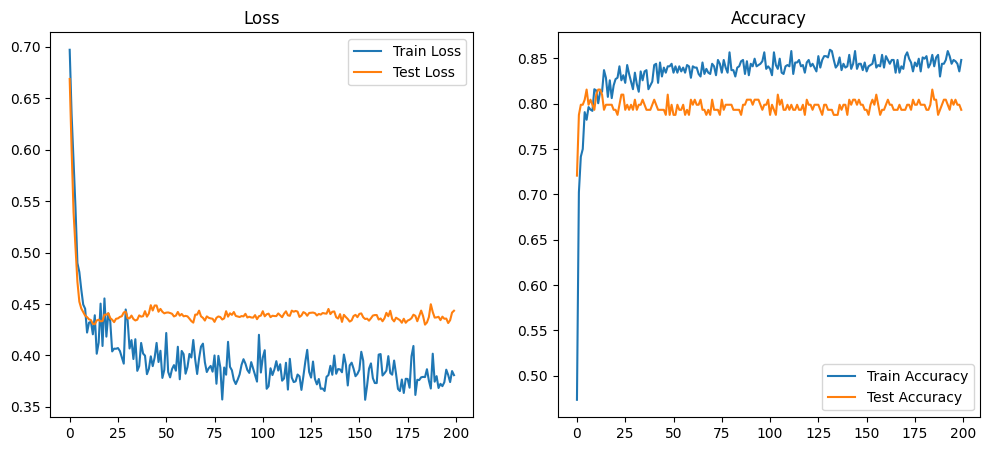

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(test_losses, label='Test Loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(train_accuracies, label='Train Accuracy')
ax[1].plot(test_accuracies, label='Test Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [14]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
y_pred_label = (y_pred > 0.5).float()

acc = accuracy_score(y_test, y_pred_label)
print(f"✅ Final accuracy: {acc:.3f}")

✅ Final accuracy: 0.793


In [15]:
# Определяем корень проекта (на уровень выше notebooks/)
project_root = Path.cwd().parent

# Создаём папку models в корне, если её нет
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)

# Путь к файлу модели
model_path = models_dir / "titanic_model.pth"

# Сохраняем модель
torch.save(model.state_dict(), model_path)
print(f"💾 Model saved to {model_path}")

💾 Model saved to C:\Users\novos\Desktop\GitHub\titanic\models\titanic_model.pth
